In [1]:
import os

import pandas as pd
import numpy as np

np.random.seed(0)

import torch

torch.set_default_dtype(torch.double)
torch.manual_seed(0)

import gpytorch
import botorch

import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
fixed_covariance_matrix_path = "../data/DB_10042_fixed_covariance_matrix.npy"
fixed_covariance_matrix = np.load(fixed_covariance_matrix_path)


def calculate_vendi_score(kernel_mat):
    if torch.is_tensor(kernel_mat):
        kernel_mat = kernel_mat.detach().numpy()
    _, s, _ = np.linalg.svd(kernel_mat / kernel_mat.shape[0])

    return np.exp(-(s * np.log(s)).sum())

# read in initial data

In [3]:
test_path = "../data/DB_10042.csv"
valid_test_path = "../data/DB_10037.csv"
train_path = "../data/Label1000.csv"

In [4]:
train_df = pd.read_csv(train_path, index_col=0)
num_init_queries = train_df.shape[0]
num_init_queries

/var/folders/wm/cr9_rg9d40sbj5kr5lkgwrlh0000gn/T/ipykernel_20764/3412296357.py:1: DtypeWarning: Columns (15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_path, index_col=0)


1000

In [5]:
iteration = 20
batch_size = 20

# target = "M_safety"
# target = "M_DBD"
target = "M_Storage"

In [6]:
def read_returned_data(target):
    test_df = pd.read_csv(test_path, index_col=0).iloc[:, 25:]
    valid_test_df = pd.read_csv(valid_test_path, index_col=0).iloc[:, 25:]
    train_df = pd.read_csv(train_path, index_col=0)
    
    returned_batch_sizes = []

    # read previous iterations' data
    for i in range(iteration):
        path = os.path.join("../data/iterations", f"iteration{i}")

        requested_df = pd.read_csv(
            os.path.join(path, f"iteration{i}_{target}_recommendations.csv"), 
            index_col=0,
        )
        returned_df = pd.read_csv(
            os.path.join(path, f"iteration{i}_{target}_recommendations_Jerry.csv"), 
            index_col=0,
        )
        returned_batch_sizes.append(returned_df.shape[0])
        requested_df["original_order"] = range(len(requested_df))

        iteration_df = returned_df.merge(
            requested_df, how="outer", left_index=True, right_index=True
        )
        iteration_df = iteration_df.sort_values(by="original_order").drop(columns="original_order")

        train_df = pd.concat([train_df, iteration_df])

    assert train_df.shape[0] == num_init_queries + iteration * batch_size
    
    test_uid = list(test_df.index)
    valid_test_uid = list(valid_test_df.index)

    filtered_test_uid = [
        this_uid for this_uid in test_uid if this_uid in valid_test_uid
    ]
    filtered_ind = [test_uid.index(ind) for ind in filtered_test_uid]

    removed_test_uid = [
        this_uid for this_uid in test_uid if this_uid not in valid_test_uid
    ]
    removed_ind = [test_uid.index(ind) for ind in removed_test_uid]

    train_uid = list(train_df.index)

    requested_ind = []
    train_ind = []
    train_y = []

    for ind in train_uid:
        assert ind in test_uid

        rel_ind = test_uid.index(ind)
        objective_value = train_df.loc[ind, target]

        # repeated experiments
        if objective_value.size > 1:
            objective_value = objective_value.iloc[0]

        requested_ind.append(rel_ind)
        if not np.isnan(objective_value):
            train_ind.append(rel_ind)
            train_y.append(objective_value)
    
    train_y = torch.tensor(train_y)
    if target == "M_DBD":
        train_y = torch.log(train_y)
    # if target == "M_safety":
    #     train_y = torch.log(train_y + 1)
    
    if target == "M_DBD":
        target_name = "log M_DBD"
    elif target == "M_safety":
        # target_name = "log M_safety+1"
        target_name = "M_safety"
    else:
        target_name = "M_Storage"

    return (
        torch.tensor(train_ind, dtype=torch.long),
        train_y,
        torch.tensor(returned_batch_sizes, dtype=torch.long),
        target_name,
    )


def compute_running_vendi_scores(labeled_ind, xs):
    vendi_scores = torch.zeros_like(xs, dtype=torch.double)
    
    for i, x_i in enumerate(xs):
        this_labeled_ind = labeled_ind[:x_i].detach().numpy().tolist()
        vendi_scores[i] = calculate_vendi_score(
            fixed_covariance_matrix[this_labeled_ind, :][:, this_labeled_ind]
        )
        
    return vendi_scores

# all objectives

In [7]:
targets = ["M_Storage", "M_DBD", "M_safety"]

train_inds = []
train_ys = []
target_names = []

for target in targets:
    train_ind, train_y, returned_batch_sizes, target_name = read_returned_data(target)
    
    train_inds.append(train_ind)
    train_ys.append(train_y)
    target_names.append(target_name)

/var/folders/wm/cr9_rg9d40sbj5kr5lkgwrlh0000gn/T/ipykernel_20764/1157947721.py:2: DtypeWarning: Columns (2,3,4,5,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv(test_path, index_col=0).iloc[:, 25:]
/var/folders/wm/cr9_rg9d40sbj5kr5lkgwrlh0000gn/T/ipykernel_20764/1157947721.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  valid_test_df = pd.read_csv(valid_test_path, index_col=0).iloc[:, 25:]
/var/folders/wm/cr9_rg9d40sbj5kr5lkgwrlh0000gn/T/ipykernel_20764/1157947721.py:4: DtypeWarning: Columns (15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_path, index_col=0)
/var/folders/wm/cr9_rg9d40sbj5kr5lkgwrlh0000gn/T/ipykernel_20764/1157947721.py:2: DtypeWarning: Columns (2,3,4,5,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set 

In [8]:
this_train_y = train_ys[2]

my_train_y = this_train_y[num_init_queries:]
baseline_train_y = this_train_y[:num_init_queries]

(my_train_y > 0).sum() / my_train_y.numel(), (baseline_train_y > 0).sum() / baseline_train_y.numel()

(tensor(0.0831), tensor(0.0630))

In [8]:
plt.style.use("seaborn-v0_8-paper")

params = {
    "figure.figsize": (8, 6),
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
}

plt.rcParams.update(params)

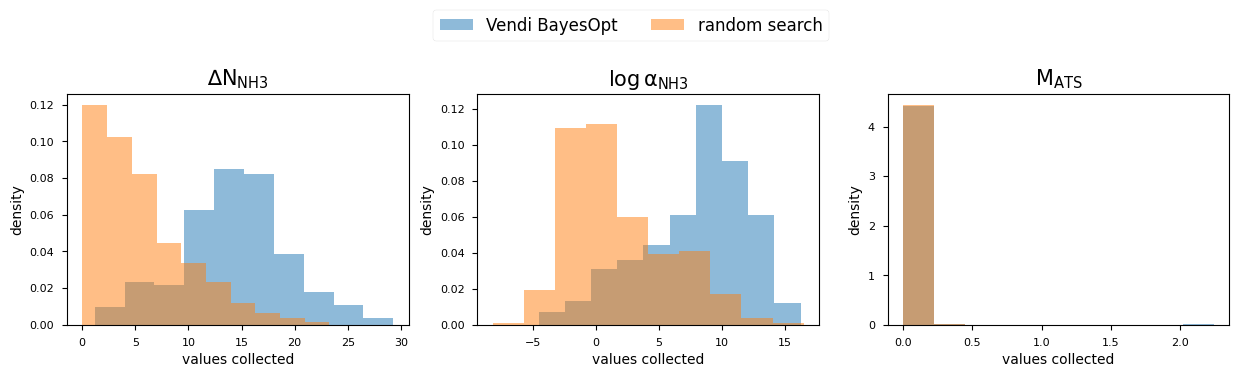

In [11]:
assert len(targets) == 3

objective_names = [r"${\rm ∆N}_{\rm NH3}$", r"$\log {\rm \alpha}_{\rm NH3}$", r"${\rm M}_{\rm ATS}$"]

fig, ax = plt.subplots(1, 3, figsize=(15, 3))

for target_i, target in enumerate(targets):
    this_train_y = train_ys[target_i]
    
    ax[target_i].hist(this_train_y[num_init_queries:], density=True, alpha=0.5, label="Vendi BayesOpt")
    ax[target_i].hist(this_train_y[:num_init_queries], density=True, alpha=0.5, label="random search")
    
    ax[target_i].set_title(objective_names[target_i], fontsize=15)
    
    ax[target_i].set_xlabel("values collected", fontsize=10)
    ax[target_i].set_ylabel("density", fontsize=10)
    
ax[2].legend(
    loc="upper center",
    bbox_to_anchor=(-0.75, 1.4),
    ncol=2, 
    frameon=True,
    fontsize=12,
)

# plt.tight_layout()
plt.show()

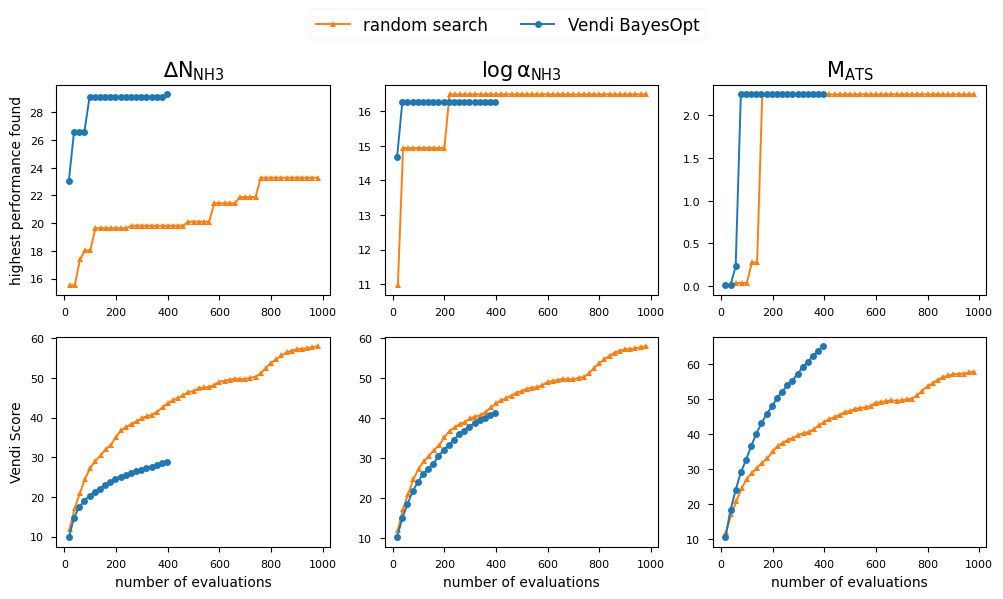

In [12]:
assert len(targets) == 3

objective_names = [r"${\rm ∆N}_{\rm NH3}$", r"$\log {\rm \alpha}_{\rm NH3}$", r"${\rm M}_{\rm ATS}$"]

my_xs = torch.cumsum(returned_batch_sizes, dim=0)
baseline_xs = torch.arange(1, num_init_queries // batch_size) * batch_size

fig, ax = plt.subplots(2, 3, figsize=(12, 6))

for target_i, target in enumerate(targets):
    this_train_ind = train_inds[target_i]
    this_train_y = train_ys[target_i]
    
    my_incumbents = torch.cummax(
        this_train_y[num_init_queries:], dim=0
    ).values[my_xs - 1]
    
    baseline_train_ind = this_train_ind.detach().numpy()[:num_init_queries]
    sorted_train_y = this_train_y.detach().numpy()[:num_init_queries][np.argsort(baseline_train_ind)].tolist()
    baseline_incumbents = torch.cummax(
        torch.tensor(sorted_train_y), dim=0
    ).values[baseline_xs - 1]
    
    my_vendi_scores = compute_running_vendi_scores(
        this_train_ind[num_init_queries:], my_xs
    )
    
    baseline_vendi_scores = compute_running_vendi_scores(
        this_train_ind[:num_init_queries], baseline_xs
    )
    
    ax[0, target_i].plot(
        baseline_xs, 
        baseline_incumbents, 
        "^-",
        markersize=5, 
        label="random search",
        c="C1",
    )
    ax[0, target_i].plot(
        my_xs, 
        my_incumbents, 
        "o-", 
        markersize=5, 
        label="Vendi BayesOpt",
    )
    
    ax[0, target_i].set_title(objective_names[target_i], fontsize=15)
    
    ax[1, target_i].plot(
        baseline_xs, 
        baseline_vendi_scores, 
        "^-", 
        markersize=5, 
        c="C1",
    )
    ax[1, target_i].plot(
        my_xs, 
        my_vendi_scores, 
        "o-", 
        markersize=5,
    )
    
    ax[1, target_i].set_xlabel("number of evaluations", fontsize=10)

ax[0, 0].set_ylabel("highest performance found", fontsize=10)
ax[1, 0].set_ylabel("Vendi Score", fontsize=10)

# ax[0, -1].legend(loc="lower right")
ax[0, -1].legend(
    loc="upper center",
    bbox_to_anchor=(-0.75, 1.4),
    ncol=2, 
    frameon=True,
    fancybox=True,
    fontsize=12,
)

plt.show()
# plt.savefig("progress.pdf", bbox_inches="tight")

In [9]:
plt.style.use("seaborn-v0_8-paper")

params = {
    "figure.figsize": (8, 6),
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
}

plt.rcParams.update(params)

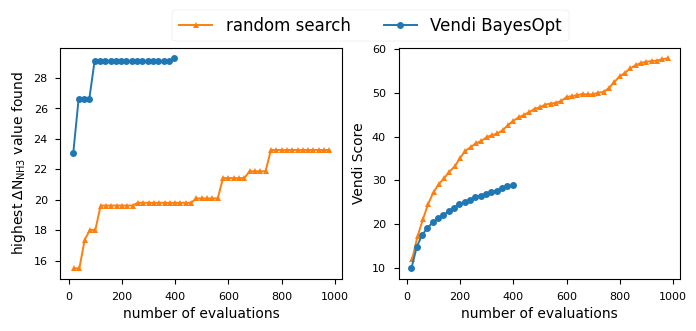

In [9]:
my_xs = torch.cumsum(returned_batch_sizes, dim=0)
baseline_xs = torch.arange(1, num_init_queries // batch_size) * batch_size

objective_names = [r"${\rm ∆N}_{\rm NH3}$", r"$\log {\rm \alpha}_{\rm NH3}$", r"${\rm M}_{\rm ATS}$"]

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

target_i = 0

this_train_ind = train_inds[target_i]
this_train_y = train_ys[target_i]

my_incumbents = torch.cummax(
    this_train_y[num_init_queries:], dim=0
).values[my_xs - 1]

baseline_train_ind = this_train_ind.detach().numpy()[:num_init_queries]
sorted_train_y = this_train_y.detach().numpy()[:num_init_queries][np.argsort(baseline_train_ind)].tolist()
baseline_incumbents = torch.cummax(
    torch.tensor(sorted_train_y), dim=0
).values[baseline_xs - 1]

my_vendi_scores = compute_running_vendi_scores(
    this_train_ind[num_init_queries:], my_xs
)

baseline_vendi_scores = compute_running_vendi_scores(
    this_train_ind[:num_init_queries], baseline_xs
)

ax[0].plot(
    baseline_xs, 
    baseline_incumbents, 
    "^-",
    markersize=5, 
    label="random search",
    c="C1",
)
ax[0].plot(
    my_xs, 
    my_incumbents, 
    "o-", 
    markersize=5, 
    label="Vendi BayesOpt",
)

ax[1].plot(
    baseline_xs, 
    baseline_vendi_scores, 
    "^-", 
    markersize=5, 
    c="C1",
)
ax[1].plot(
    my_xs, 
    my_vendi_scores, 
    "o-", 
    markersize=5,
)

ax[0].set_xlabel("number of evaluations", fontsize=10)
ax[1].set_xlabel("number of evaluations", fontsize=10)

ax[0].set_ylabel(f"highest {objective_names[target_i]} value found", fontsize=10)
ax[1].set_ylabel("Vendi Score", fontsize=10)

# ax[0, -1].legend(loc="lower right")
ax[0].legend(
    loc="upper center",
    bbox_to_anchor=(1.1, 1.2),
    ncol=2, 
    frameon=True,
    fancybox=True,
    fontsize=12,
)

# plt.tight_layout()
plt.show()
# plt.savefig("progress.pdf", bbox_inches="tight")

In [29]:
(
    this_train_y[num_init_queries:].mean(),
    torch.tensor(sorted_train_y).mean(),
)

(tensor(14.3029), tensor(5.5635))

In [32]:
(
    torch.cumsum(torch.tensor(sorted_train_y), dim=0)
    / torch.arange(1, len(sorted_train_y) + 1)
)

tensor([2.9286, 8.3349, 5.6368, 5.2213, 5.5599, 4.7833, 4.1998, 4.4281, 4.1157,
        3.7288, 4.1028, 4.2544, 4.0924, 4.5869, 5.1301, 4.8747, 5.5005, 5.5582,
        5.9180, 5.7121, 5.4817, 5.3057, 5.2959, 5.4744, 5.2866, 5.0861, 4.9300,
        5.0324, 5.1557, 5.0449, 4.9334, 4.9638, 4.8873, 4.8286, 4.7948, 4.6903,
        4.9514, 5.0562, 5.1468, 5.0703, 5.0389, 5.0483, 4.9610, 4.8575, 4.8004,
        4.7390, 4.7444, 4.8749, 4.8206, 4.8598, 4.8879, 4.8160, 5.0532, 4.9660,
        4.8949, 4.8130, 4.8724, 4.8898, 4.9010, 4.8707, 4.8728, 4.9134, 4.8480,
        4.7936, 4.7486, 4.7097, 4.8526, 4.7819, 4.8189, 4.7845, 4.7256, 4.8007,
        4.9819, 4.9932, 4.9393, 4.9026, 4.9823, 4.9353, 4.8858, 4.8746, 4.9466,
        4.9245, 5.0475, 5.0540, 5.0682, 5.0876, 5.1411, 5.1288, 5.1787, 5.1477,
        5.1039, 5.2083, 5.1546, 5.1593, 5.1643, 5.1841, 5.1749, 5.2017, 5.2040,
        5.1882, 5.3312, 5.3262, 5.2850, 5.2566, 5.2535, 5.2398, 5.1931, 5.1798,
        5.2763, 5.2803, 5.2807, 5.2756, 

In [31]:
(
    torch.cumsum(this_train_y[num_init_queries:], dim=0) 
    / torch.arange(1, this_train_y.numel() - num_init_queries + 1)
)

tensor([19.2435, 20.4620, 18.0005, 19.2681, 18.6387, 17.9456, 17.9620, 18.3431,
        17.6070, 17.0766, 16.6010, 16.7978, 16.2495, 16.7051, 16.0795, 16.0880,
        15.6882, 15.5936, 15.8032, 15.7992, 15.7230, 15.5201, 15.0206, 14.5635,
        14.6115, 14.6862, 14.8734, 15.1853, 15.1581, 15.0509, 15.1366, 15.1710,
        14.9800, 15.0690, 15.3154, 15.4520, 15.7530, 15.6437, 15.5495, 15.6915,
        15.7624, 15.7558, 15.8355, 15.6059, 15.6323, 15.5210, 15.2693, 15.3081,
        15.1017, 15.1067, 14.8955, 14.7313, 14.8025, 14.6273, 14.6216, 14.7263,
        14.7310, 14.8644, 14.9010, 14.9306, 14.9635, 14.9795, 14.9702, 14.8689,
        14.8811, 14.9612, 14.9626, 14.9311, 14.9394, 15.0077, 14.9672, 14.9506,
        14.8906, 14.8523, 14.9281, 14.9432, 14.9669, 15.0345, 15.0802, 15.0804,
        15.1201, 15.1000, 15.1118, 15.2781, 15.3353, 15.3050, 15.3120, 15.1930,
        15.1878, 15.1890, 15.1989, 15.2480, 15.2567, 15.2324, 15.2061, 15.0992,
        14.9756, 15.0409, 15.0569, 15.13

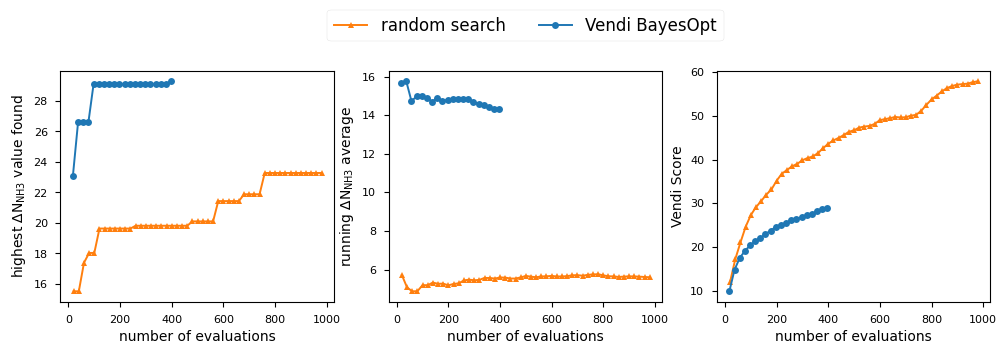

In [37]:
my_xs = torch.cumsum(returned_batch_sizes, dim=0)
baseline_xs = torch.arange(1, num_init_queries // batch_size) * batch_size

objective_names = [r"${\rm ∆N}_{\rm NH3}$", r"$\log {\rm \alpha}_{\rm NH3}$", r"${\rm M}_{\rm ATS}$"]

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

target_i = 0

this_train_ind = train_inds[target_i]
this_train_y = train_ys[target_i]

my_incumbents = torch.cummax(
    this_train_y[num_init_queries:], dim=0
).values[my_xs - 1]

baseline_train_ind = this_train_ind.detach().numpy()[:num_init_queries]
sorted_train_y = this_train_y.detach().numpy()[:num_init_queries][np.argsort(baseline_train_ind)].tolist()
baseline_incumbents = torch.cummax(
    torch.tensor(sorted_train_y), dim=0
).values[baseline_xs - 1]

my_avg_values = (
    torch.cumsum(this_train_y[num_init_queries:], dim=0) 
    / torch.arange(1, this_train_y.numel() - num_init_queries + 1)
)[my_xs - 1]
baseline_avg_values = (
    torch.cumsum(torch.tensor(sorted_train_y), dim=0)
    / torch.arange(1, len(sorted_train_y) + 1)
)[baseline_xs - 1]

my_vendi_scores = compute_running_vendi_scores(
    this_train_ind[num_init_queries:], my_xs
)

baseline_vendi_scores = compute_running_vendi_scores(
    this_train_ind[:num_init_queries], baseline_xs
)

ax[0].plot(
    baseline_xs, 
    baseline_incumbents, 
    "^-",
    markersize=5, 
    label="random search",
    c="C1",
)
ax[0].plot(
    my_xs, 
    my_incumbents, 
    "o-", 
    markersize=5, 
    label="Vendi BayesOpt",
)

ax[1].plot(
    baseline_xs,
    baseline_avg_values,
    "^-",
    markersize=5, 
    label="random search",
    c="C1",
)
ax[1].plot(
    my_xs, 
    my_avg_values, 
    "o-", 
    markersize=5, 
    label="Vendi BayesOpt",
)

ax[2].plot(
    baseline_xs, 
    baseline_vendi_scores, 
    "^-", 
    markersize=5, 
    c="C1",
)
ax[2].plot(
    my_xs, 
    my_vendi_scores, 
    "o-", 
    markersize=5,
)

ax[0].set_xlabel("number of evaluations", fontsize=10)
ax[1].set_xlabel("number of evaluations", fontsize=10)
ax[2].set_xlabel("number of evaluations", fontsize=10)

ax[0].set_ylabel(f"highest {objective_names[target_i]} value found", fontsize=10)
ax[1].set_ylabel(f"running {objective_names[target_i]} average", fontsize=10)
ax[2].set_ylabel("Vendi Score", fontsize=10)

# ax[0, -1].legend(loc="lower right")
ax[1].legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.3),
    ncol=2, 
    frameon=True,
    fancybox=True,
    fontsize=12,
)

# plt.tight_layout()
plt.show()
# plt.savefig("progress.pdf", bbox_inches="tight")

In [38]:
def compute_running_topk_values(labeled_y, k=1):
    topk_values = torch.zeros(labeled_y.numel(), k, dtype=torch.double)
    
    for i in range(1, labeled_y.numel() + 1):
        if i < k:
            this_topk_values, _ = torch.topk(labeled_y[:i], i)
            topk_values[i - 1, :i] = this_topk_values
        else:
            this_topk_values, _ = torch.topk(labeled_y[:i], k)
            topk_values[i - 1, :] = this_topk_values
            
    return topk_values

In [43]:
baseline_topk_values.mean(axis=-1).shape

torch.Size([1000])

In [39]:
k = 20

baseline_topk_values = compute_running_topk_values(
    torch.tensor(
        np.array(
            this_train_y[:num_init_queries]
        )[np.argsort(train_ind[:num_init_queries].detach().numpy())]
    ),
    k=k
)
my_topk_values = compute_running_topk_values(this_train_y[num_init_queries:], k=k)

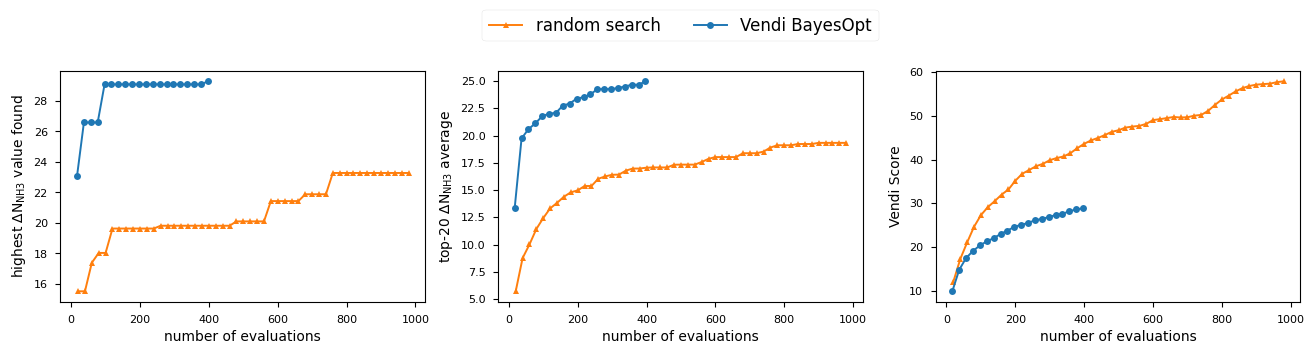

In [47]:
my_xs = torch.cumsum(returned_batch_sizes, dim=0)
baseline_xs = torch.arange(1, num_init_queries // batch_size) * batch_size

objective_names = [r"${\rm ∆N}_{\rm NH3}$", r"$\log {\rm \alpha}_{\rm NH3}$", r"${\rm M}_{\rm ATS}$"]

fig, ax = plt.subplots(1, 3, figsize=(16, 3))

target_i = 0

this_train_ind = train_inds[target_i]
this_train_y = train_ys[target_i]

my_incumbents = torch.cummax(
    this_train_y[num_init_queries:], dim=0
).values[my_xs - 1]

baseline_train_ind = this_train_ind.detach().numpy()[:num_init_queries]
sorted_train_y = this_train_y.detach().numpy()[:num_init_queries][np.argsort(baseline_train_ind)].tolist()
baseline_incumbents = torch.cummax(
    torch.tensor(sorted_train_y), dim=0
).values[baseline_xs - 1]

my_avg_values = (
    torch.cumsum(this_train_y[num_init_queries:], dim=0) 
    / torch.arange(1, this_train_y.numel() - num_init_queries + 1)
)[my_xs - 1]
baseline_avg_values = (
    torch.cumsum(torch.tensor(sorted_train_y), dim=0)
    / torch.arange(1, len(sorted_train_y) + 1)
)[baseline_xs - 1]

my_vendi_scores = compute_running_vendi_scores(
    this_train_ind[num_init_queries:], my_xs
)

baseline_vendi_scores = compute_running_vendi_scores(
    this_train_ind[:num_init_queries], baseline_xs
)

ax[0].plot(
    baseline_xs, 
    baseline_incumbents, 
    "^-",
    markersize=5, 
    label="random search",
    c="C1",
)
ax[0].plot(
    my_xs, 
    my_incumbents, 
    "o-", 
    markersize=5, 
    label="Vendi BayesOpt",
)

ax[1].plot(
    baseline_xs,
    baseline_topk_values.mean(axis=-1)[baseline_xs - 1],
    "^-",
    markersize=5, 
    label="random search",
    c="C1",
)
ax[1].plot(
    my_xs, 
    my_topk_values.mean(axis=-1)[my_xs - 1], 
    "o-", 
    markersize=5, 
    label="Vendi BayesOpt",
)

ax[2].plot(
    baseline_xs, 
    baseline_vendi_scores, 
    "^-", 
    markersize=5, 
    c="C1",
)
ax[2].plot(
    my_xs, 
    my_vendi_scores, 
    "o-", 
    markersize=5,
)

ax[0].set_xlabel("number of evaluations", fontsize=10)
ax[1].set_xlabel("number of evaluations", fontsize=10)
ax[2].set_xlabel("number of evaluations", fontsize=10)

ax[0].set_ylabel(f"highest {objective_names[target_i]} value found", fontsize=10)
ax[1].set_ylabel(f"top-{k} {objective_names[target_i]} average", fontsize=10)
ax[2].set_ylabel("Vendi Score", fontsize=10)

# ax[0, -1].legend(loc="lower right")
ax[1].legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.3),
    ncol=2, 
    frameon=True,
    fancybox=True,
    fontsize=12,
)

# plt.tight_layout()
plt.show()
# plt.savefig("progress.pdf", bbox_inches="tight")

# one objective and VS

In [14]:
my_xs = torch.cumsum(returned_batch_sizes, dim=0)
my_incumbents = torch.cummax(
    train_y[num_init_queries:], dim=0
).values[my_xs - 1]

baseline_xs = torch.arange(1, num_init_queries // batch_size) * batch_size
baseline_incumbents = torch.cummax(
    train_y[:num_init_queries], dim=0
).values[baseline_xs - 1]

In [15]:
my_vendi_scores = compute_running_vendi_scores(
    train_ind[num_init_queries:], my_xs
)

baseline_vendi_scores = compute_running_vendi_scores(
    train_ind[:num_init_queries], baseline_xs
)

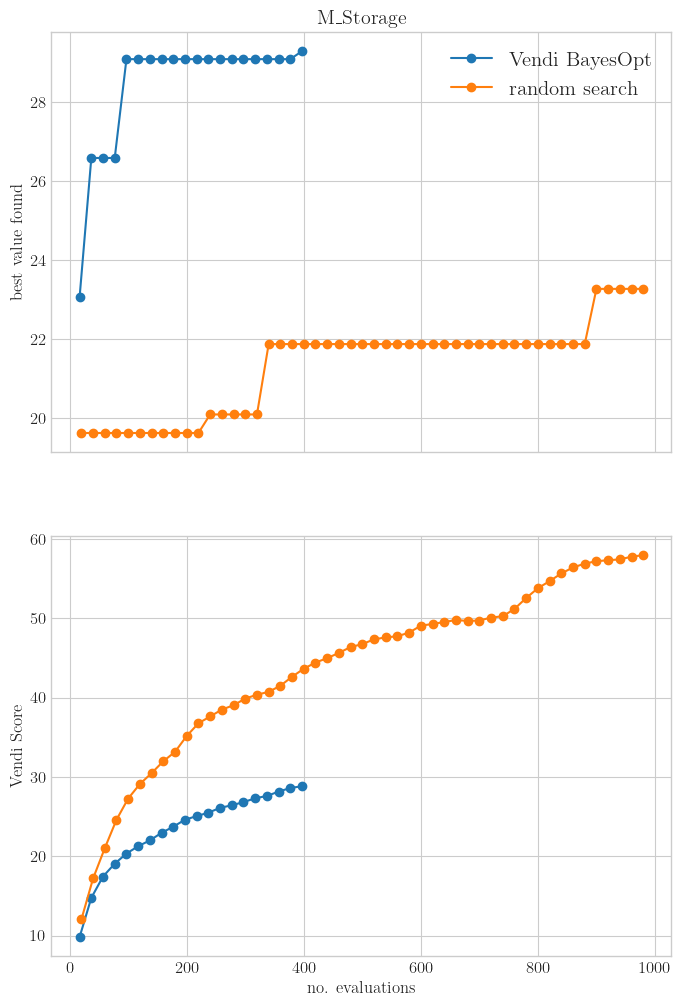

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(8, 12), sharex=True)

ax[0].plot(my_xs, my_incumbents, "o-", label="Vendi BayesOpt")
ax[0].plot(baseline_xs, baseline_incumbents, "o-", label="random search")

ax[0].set_title(target)
ax[0].set_ylabel("best value found")
ax[0].legend()

ax[1].plot(my_xs, my_vendi_scores, "o-")
ax[1].plot(baseline_xs, baseline_vendi_scores, "o-")

ax[1].set_xlabel("no. evaluations")
ax[1].set_ylabel("Vendi Score")

plt.show()

# one objective only

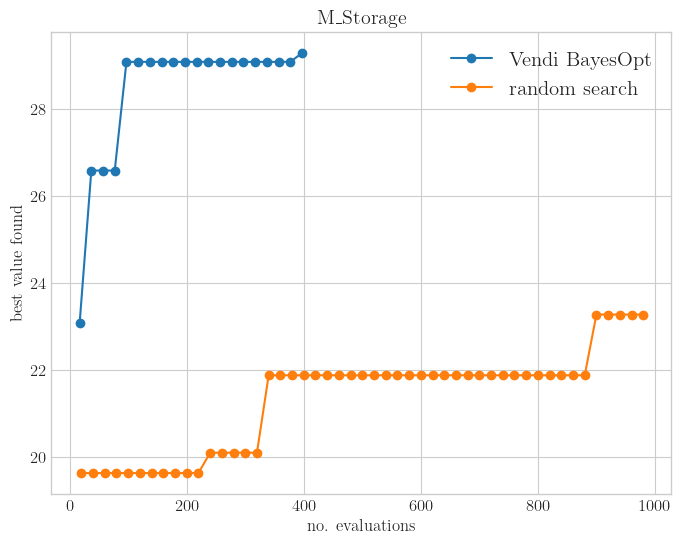

In [12]:
my_xs = torch.cumsum(returned_batch_sizes, dim=0)
my_incumbents = torch.cummax(
    train_y[num_init_queries:], dim=0
).values[my_xs - 1]

baseline_xs = torch.arange(1, num_init_queries // batch_size) * batch_size
baseline_incumbents = torch.cummax(
    train_y[:num_init_queries], dim=0
).values[baseline_xs - 1]

plt.plot(my_xs, my_incumbents, "o-", label="Vendi BayesOpt")
plt.plot(baseline_xs, baseline_incumbents, "o-", label="random search")

plt.title(target)
plt.ylabel("best value found")
plt.xlabel("no. evaluations")

plt.legend()
plt.show()